<a href="https://colab.research.google.com/github/AiArThy/quickdraw-detection-model/blob/main/flask_server.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/final

/content/gdrive/MyDrive/final


In [3]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools tf_slim

%cd /content/gdrive/MyDrive/final/models/research
!protoc object_detection/protos/*.proto --python_out=.

Selecting previously unselected package python-bs4.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [4]:

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import numpy as np
from PIL import Image

In [49]:
model = tf.saved_model.load(str('/content/gdrive/MyDrive/final/training/saved_model/4'))

In [6]:
import os
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/final/models/research/:/content/gdrive/MyDrive/final/models/research/slim/'

In [ ]:

tf.__version__

'2.4.1'

In [7]:
print(model.signatures['serving_default'].inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [8]:

model.signatures['serving_default'].output_shapes

{'detection_boxes': TensorShape([None, 300, 4]),
 'detection_classes': TensorShape([None, 300]),
 'detection_scores': TensorShape([None, 300]),
 'num_detections': TensorShape([None])}

In [9]:
model.signatures['serving_default'].output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [10]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
  print(output_dict)
  return output_dict

In [53]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  #image_np = np.dstack([image_np]*3) # <- if gray (channel 1) image
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  print(output_dict)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))
  return output_dict

In [12]:
PATH_TO_LABELS = '/content/gdrive/MyDrive/final/training/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

{'detection_boxes': array([[0.8638484 , 0.27119595, 0.96566993, 0.37041   ],
       [0.49279922, 0.7860833 , 0.5941737 , 0.88485026],
       [0.34179294, 0.22676697, 0.4433114 , 0.32695997],
       [0.71661246, 0.66370904, 0.81855446, 0.7607243 ],
       [0.5900192 , 0.62935376, 0.686791  , 0.728934  ],
       [0.10351322, 0.49205178, 0.20335166, 0.590448  ],
       [0.02129493, 0.48101693, 0.09426424, 0.58042145],
       [0.14669268, 0.8360253 , 0.24589697, 0.93695015],
       [0.64114493, 0.00525619, 0.74284416, 0.09351487],
       [0.6639084 , 0.85380524, 0.76285046, 0.9514384 ],
       [0.23657131, 0.39223954, 0.337518  , 0.4945854 ],
       [0.4772681 , 0.61790365, 0.5778813 , 0.717086  ],
       [0.8360972 , 0.48571768, 0.9367701 , 0.58912224],
       [0.3913053 , 0.39831218, 0.49009198, 0.49881336]], dtype=float32), 'detection_scores': array([0.9975667 , 0.9845792 , 0.9844887 , 0.9810852 , 0.9801468 ,
       0.9796668 , 0.96854454, 0.96775   , 0.95963633, 0.8904895 ,
       0.88

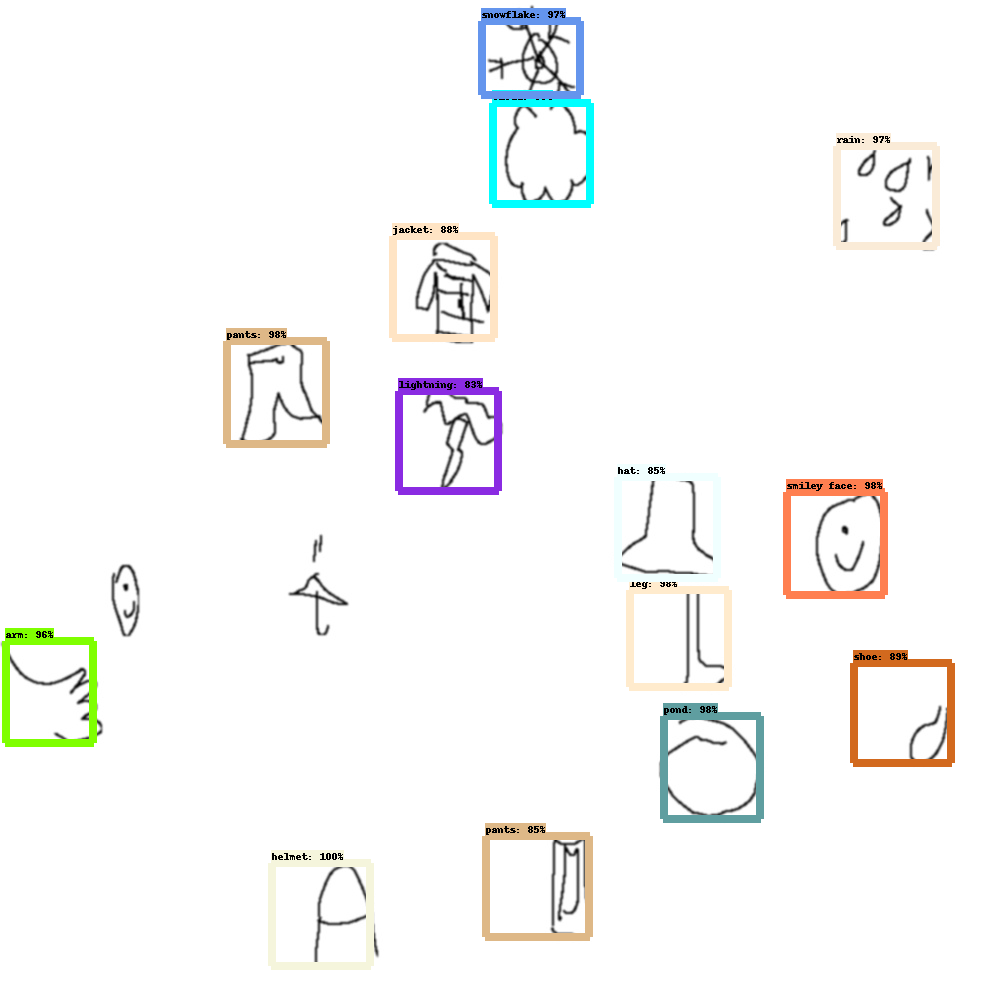

In [54]:
output = show_inference(model, '/content/0.jpg')

In [13]:
!pip install flask-ngrok

In [16]:
%cd /content/gdrive/MyDrive/quickdraw-web/quickdraw-web

/content/gdrive/MyDrive/quickdraw-web/quickdraw-web


In [31]:
from math import *
from collections import namedtuple
import json

detection_classes = [1, 2, 3, 4, 5, 6, 7, 8]
detection_boxes = [[0.8, 0.2, 0.9, 0.4], [0.3, 0.2, 0.4, 0.3], [0.01, 0.4, 0.07, 0.6], [0.1, 0.5, 0.2, 0.6],
                    [0.7, 0.6, 0.8, 0.7], [0.1, 0.8, 0.2, 0.9], [0.97, 0.3, 0.96, 0.2], [0.1, 0.2, 0.3, 0.4]]


def solution(detection_classes, detection_boxes):

  Box = namedtuple('Box', 'xmin ymin xmax ymax width height')

  def box_by_name(object) :
      return Box(detection_boxes[detection_classes.index(object)][0], detection_boxes[detection_classes.index(object)][1],
          detection_boxes[detection_classes.index(object)][2], detection_boxes[detection_classes.index(object)][3], 
          detection_boxes[detection_classes.index(object)][2]-detection_boxes[detection_classes.index(object)][0],
          detection_boxes[detection_classes.index(object)][3]-detection_boxes[detection_classes.index(object)][1])
          
  def box_by_index(index) :
      return Box(detection_boxes[index][0], detection_boxes[index][1],
          detection_boxes[index][2], detection_boxes[index][3], 
          detection_boxes[index][2]-detection_boxes[index][0],
          detection_boxes[index][3]-detection_boxes[index][1])

  def isOverlapping(obj1, obj2):
      return ((obj1.xmin <= obj2.xmax) and (obj2.xmin <= obj1.xmax) and (obj1.ymin <= obj2.ymax) and (obj2.ymin <= obj1.ymax)) 

  stress = 0
  resource = 0
  rain = 0
  person = 1

  data = {}
  data['stress'] = []
  data['resource'] = []
  data['result'] = []

  data['stress'].append({"stress_intro" : "우선, 스트레스를 의미하는 외부적 요인에 대해 먼저 살펴보겠습니다."})

  data['resource'].append({"intro" : "이제, 그림 속의 사람이 비에 대해 어떻게 대처하고 있는지를 살펴보겠습니다."})
  data['resource'].append({"person_intro" : "사람은 내담자의 자화상 또는 이상형을 의미합니다. 신체를 다 그리지 않고 생략하는 것은 현재 심리적인 갈등을 나타냅니다."})

  if 3 in detection_classes and (detection_classes.count(1) == 2 or 6 in detection_classes or 15 in detection_classes) and (detection_classes.count(7) == 2 or 9 in detection_classes) :
      data['resource'].append({"person" : "그림 속의 사람이 온전한 형상을 갖추었습니다."})
      
  else : 
      no_person = []
      resource -= 1
      if 3 not in detection_classes : 
          no_person.append("얼굴이 없는 사람을 그린 사람은 사람들의 관심을 끌기를 원하지 않습니다.")
      if detection_classes.count(1) != 2 and 6 not in detection_classes and 15 not in detection_classes: 
          no_person.append("손이 생략되어 있다면 부적응이 크다는 것을 나타냅니다.")
      if detection_classes.count(7) != 2 and 9 not in detection_classes : 
          no_person.append("발이 생략되어 있다면 자신에 대한 통제가 결여되어 있음을 나타냅니다.")
      data['resource'].append({"person" : ' '.join(no_person)})

      if 3 not in detection_classes and detection_classes.count(1) == 0 and detection_classes.count(7) == 0 and 6 not in detection_classes and 15 not in detection_classes and 9 not in detection_classes :
          person = 0

  if person == 1 :
      person_xmin_list = []
      person_xmax_list = []
      person_ymin_list = []
      person_ymax_list = []

      arm_box = []
      arm_xmin_list = []
      arm_xmax_list = []
      arm_ymin_list = []
      arm_ymax_list = []

      arm_indices = [i for i, x in enumerate(detection_classes) if x == 1]

      for i in arm_indices :
          arm_box.append(box_by_index(i))

      if 6 in detection_classes :
          arm_box.append(box_by_name(6))
      elif 15 in detection_classes :
          arm_box.append(box_by_name(15))

      for box in arm_box :
          arm_xmin_list.append(box.xmin)
          arm_xmax_list.append(box.xmax)
          arm_ymin_list.append(box.ymin)
          arm_ymax_list.append(box.ymax)

      if arm_box :
          person_xmin_list.append(min(arm_xmin_list))
          person_xmax_list.append(max(arm_xmax_list))
          person_ymin_list.append(min(arm_ymin_list))
          person_ymax_list.append(max(arm_ymax_list))

      leg_box = []
      leg_xmin_list = []
      leg_xmax_list = []
      leg_ymin_list = []
      leg_ymax_list = []

      leg_indices = [i for i, x in enumerate(detection_classes) if x == 7]

      for i in leg_indices :
          leg_box.append(box_by_index(i))

      if 9 in detection_classes :
          leg_box.append(box_by_name(9))

      for box in leg_box :
          leg_xmin_list.append(box.xmin)
          leg_xmax_list.append(box.xmax)
          leg_ymin_list.append(box.ymin)
          leg_ymax_list.append(box.ymax)

      if leg_box :
          person_xmin_list.append(min(leg_xmin_list))
          person_xmax_list.append(max(leg_xmax_list))
          person_ymin_list.append(min(leg_ymin_list))
          person_ymax_list.append(max(leg_ymax_list))

      if 3 in detection_classes :
          person_xmin_list.append(box_by_name(3).xmin)
          person_xmax_list.append(box_by_name(3).xmax)
          person_ymin_list.append(box_by_name(3).ymin)
          person_ymax_list.append(box_by_name(3).ymax)

      person_xmin = min(person_xmin_list)
      person_xmax = max(person_xmax_list)
      person_ymin = min(person_ymin_list)
      person_ymax = max(person_ymax_list)

      person_box = Box(person_xmin, person_ymin, person_xmax, person_xmax, person_xmax-person_xmin, person_ymax-person_ymin)

  # stress score calculate
  if 11 in detection_classes : 
      stress += 1
      data['stress'].append({"rain" : "비는 외부적 곤란이나 스트레스 상황을 의미합니다."})
      rain_box = box_by_name(11)
      if person == 1 : 
          if rain_box.width * rain_box.height >= 1.5 * person_box.width * person_box.height :
              stress += 1
              data['stress'].append({"rain_amount" : "비가 많이 내리고 있는 것을 보아 스트레스 정도가 높네요."})
          else :
              data['stress'].append({"rain_amount" : "비가 적게 내리고 있는 것을 보아 스트레스 정도가 낮네요."})
          if isOverlapping(rain_box, person_box) :
              stress += 1
              data['stress'].append({"rain_with_person" : "인물이 비를 맞고 있는 것은 스트레스에 대처할 방법을 찾지 못하고 있는 상황임을 뜻합니다."})


  bad_obj = []
  on_bad_obj = 0

  if 10 in detection_classes : 
      stress += 1
      bad_obj.append("웅덩이")
      pond_box = []
      pond_indices = [i for i, x in enumerate(detection_classes) if x == 10]
      for i in pond_indices :
          pond_box.append(box_by_index(i))
      
      for box in pond_box :
          if person == 1 and isOverlapping(box, person_box) :
              stress += 1
              on_bad_obj = 1
              break

  if 14 in detection_classes : 
      stress += 1
      bad_obj.append("눈")
      snow_box = []
      snow_indices = [i for i, x in enumerate(detection_classes) if x == 14]
      for i in snow_indices :
          snow_box.append(box_by_index(i))
      
      for box in snow_box :
          if person == 1 and isOverlapping(box, person_box) :
              stress += 1
              on_bad_obj = 1
              break
      
  if 8 in detection_classes : 
      stress += 1
      bad_obj.append("번개")
      lightning_box = []
      lightning_indices = [i for i, x in enumerate(detection_classes) if x == 8]
      for i in lightning_indices :
          lightning_box.append(box_by_index(i))
      
      for box in lightning_box :
          if person == 1 and isOverlapping(box, person_box) :
              stress += 1
              on_bad_obj = 1
              break

  if 2 in detection_classes : 
      stress += 1
      bad_obj.append("구름")
      cloud_box = []
      cloud_indices = [i for i, x in enumerate(detection_classes) if x == 2]
      for i in cloud_indices :
          cloud_box.append(box_by_index(i))
      
      for box in cloud_box :
          if person == 1 and isOverlapping(box, person_box) :
              stress += 1
              on_bad_obj = 1
              break

  if bad_obj :
      data['stress'].append({"extra" : ','.join(bad_obj) + "은/는 추가적인 스트레스 상황을 의미합니다."})
  if on_bad_obj == 1 :
      data['stress'].append({"extra_with_person" : "특히, 인물이 접촉하고 있는 것을 보아 그 스트레스 정도가 더욱 높다고 판단할 수 있습니다."})
      
  # resource score calculate
  if 16 in detection_classes : 
      resource += 1
      umbrella_box = box_by_name(16)
      data['resource'].append({"umbrealla" : "우산은 스트레스의 대처방안을 의미합니다."})
      
      if person == 1 :
          if umbrella_box.width >= person_box.width :
              resource += 1
              data['resource'].append({"umbrealla_with_person" : "우산을 잘 받쳐 들고 있는 것을 보아 스트레스를 직접적으로 잘 대처하고 있네요."})
          else :
              data['resource'].append({"umbrealla_with_person" : "우산은 있지만 비를 맞고 있는 것을 보아 스트레스에 잘 대처하고 있지 못하네요."})

  good_obj = []

  if 4 in detection_classes or 5 in detection_classes : 
      resource += 1
      good_obj.append("모자")
      
  if 12 in detection_classes : 
      resource += 1
      good_obj.append("신발")

  if 6 in detection_classes or 15 in detection_classes :
      resource += 1
      good_obj.append("옷(상의)")

  if 9 in detection_classes : 
      resource += 1
      good_obj.append("옷(바지)")

  if good_obj :
      data['resource'].append({"extra" : ','.join(good_obj) + "은/는 추가적인 스트레스의 대처방안을 의미합니다."})
      
  if 3 in detection_classes : 
      resource += 1

  if 13 in detection_classes : 
      resource += 1
      data['resource'].append({"smiley_face" : "사람이 웃고 있는 것을 보아 행복한 심리상태를 반영했네요."})
      
  if person == 1 :
      center_point = Box(0.5, 0.5, 0.5, 0.5, 0, 0)
      if isOverlapping(center_point, person_box) :
          resource += 1
          data['resource'].append({"center" : "사람이 그림 중앙에 위치하고 있습니다."})
      else :
          data['resource'].append({"center" : "사람이 그림 가장자리에 치우쳐 있습니다."})

      if person_box.width >= 0.3 and person_box.height >= 0.3 and person_box.width <= 0.7 and person_box.height <= 0.7 :
          resource += 1
          data['resource'].append({"size" : "사람이 적당한 크기로 표현이 되어 있는 것을 보아 자아가 올바른 상태로 내면에 힘이 있는 편이이라는 것을 알 수 있습니다."})
      elif person_box.width < 0.3 and person_box.height < 0.3 :
          data['resource'].append({"size" : "사람이 지나치게 작게 표현이 되어 있는 것을 보아 자아가 약한 상태로 내면에 힘이 약화된 편이라고 볼 수 있습니다."})
      elif person_box.width > 0.7 and person_box.height > 0.7 :
          data['resource'].append({"size" : "사람이 지나치게 크게 표현이 되어 있는 것을 보아 자아가 지나치게 강한 상태로 스트레스에 올바르게 대처하기 힘든 편이라고 볼 수 있습니다."})
      else :
          data['resource'].append({"size" : "사람이 적당하지 않은 크기로 표현이 되어 있는 것을 보아 자아가 올바르지 않은 상태라는 것을 알 수 있습니다."})

  if resource - stress >= 0 :
      data['result'].append({"result" : "당신은 스트레스를 받으면서도 자신이 그렇게 무력하지 않다고 생각하며, 충분히 대처할 수 있는 능력을 갖고 있습니다. 스트레스에 대한 대처 능력이 있어서 심하게 두려워하거나 불안해하지 않는 사람은 대부분 비옷이나 비를 피하는 옷, 혹은 우산을 펴고 만족한 표정을 짓고 있는 모습을 그립니다."})
  else :
      data['result'].append({"result" : "당신은 지금 상당한 스트레스 환경이나 상황에 놓여 있으며, 그 상황에 대처하기 힘들어 합니다. 스트레스에 대한 대처 능력이 없어서 조그만한 불안에도 심하게 반응하는 사람은 아주 겁에 질렸거나 무기력한 상황을 그립니다."})

  print(data)

  return data


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://0950b9622ba0.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [22/Apr/2021 18:21:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2021 18:21:09] "GET /static/common.css HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2021 18:21:10] "GET /static/main2.png HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2021 18:21:11] "GET /canvas HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2021 18:21:11] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [22/Apr/2021 18:21:18] "POST /uploadFile/file HTTP/1.1" 302 -


hello


127.0.0.1 - - [22/Apr/2021 18:21:19] "GET /uploadFile/file HTTP/1.1" 405 -


{'detection_boxes': array([], shape=(0, 4), dtype=float32), 'detection_scores': array([], dtype=float32), 'detection_classes': array([], dtype=int64), 'num_detections': 0}
{'detection_boxes': array([], shape=(0, 4), dtype=float32), 'detection_scores': array([], dtype=float32), 'detection_classes': array([], dtype=int64), 'num_detections': 0}


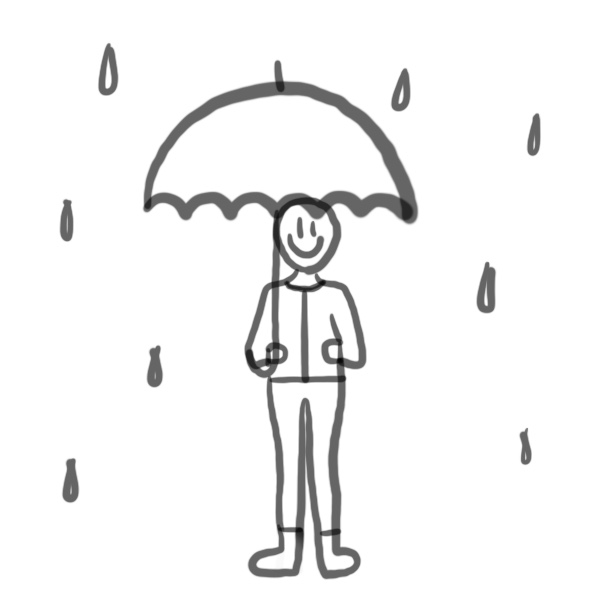

127.0.0.1 - - [22/Apr/2021 18:21:21] "GET /analyze HTTP/1.1" 200 -


[]
[]
{'stress': [{'stress_intro': '우선, 스트레스를 의미하는 외부적 요인에 대해 먼저 살펴보겠습니다.'}, {'rain': '비는 외부적 곤란이나 스트레스 상황을 의미합니다.'}, {'rain_amount': '비가 많이 내리고 있는 것을 보아 스트레스 정도가 높네요.'}, {'rain_with_person': '인물이 비를 맞고 있는 것은 스트레스에 대처할 방법을 찾지 못하고 있는 상황임을 뜻합니다.'}], 'resource': [{'intro': '이제, 그림 속의 사람이 비에 대해 어떻게 대처하고 있는지를 살펴보겠습니다.'}, {'person_intro': '사람은 내담자의 자화상 또는 이상형을 의미합니다. 신체를 다 그리지 않고 생략하는 것은 현재 심리적인 갈등을 나타냅니다.'}, {'person': '그림 속의 사람이 온전한 형상을 갖추었습니다.'}, {'umbrealla': '우산은 스트레스의 대처방안을 의미합니다.'}, {'umbrella_with_person': '우산을 잘 받쳐 들고 있는 것을 보아 스트레스를 직접적으로 잘 대처하고 있네요.'}, {'smiley_face': '사람이 웃고 있는 것을 보아 행복한 심리상태를 반영했네요.'}, {'size': '사람이 적당한 크기로 표현이 되어 있는 것을 보아 자아가 올바른 상태로 내면에 힘이 있는 편이라는 것을 알 수 있습니다.'}], 'result': [{'result': '당신은 스트레스를 받으면서도 자신이 그렇게 무력하지 않다고 생각하며, 충분히 대처할 수 있는 능력을 갖고 있습니다. 스트레스에 대한 대처 능력이 있어서 심하게 두려워하거나 불안해하지 않는 사람은 대부분 비옷이나 비를 피하는 옷, 혹은 우산을 펴고 만족한 표정을 짓고 있는 모습을 그립니다.'}]}


127.0.0.1 - - [22/Apr/2021 18:21:22] "GET /static/drawing.png HTTP/1.1" 200 -


In [48]:
import os
from PIL import Image
from flask import Flask, render_template, request, jsonify, redirect, url_for
from flask_ngrok import run_with_ngrok

from werkzeug.utils import secure_filename

app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def main():
	return render_template('index.html', css_path = 'common.css', image_path = 'main2.png')

@app.route("/about")
def about():
	return render_template('about.html')

@app.route("/canvas")
def canvas():
	return render_template('canvas.html')

@app.route("/uploadFile/<path>", methods = ['POST'])
def upload_file(path):

	file = request.files['file']
	if path == 'file':
		if file.filename == '':
			return redirect(url_for('canvas'))
		else:
			file.save('static/drawing.png')
    
	elif path == 'canvas':
		img = Image.open(file.stream)
		img = img.resize((1000, 1000), Image.ANTIALIAS)
		img.save('static/drawing.png')
	return redirect(url_for('analyze'))

@app.route("/analyze", methods=['GET'])
def analyze():
  output = show_inference(model, 'static/drawing.png')
  # print(output['detection_classes'].tolist())
  # print(output['detection_boxes'].tolist())
  analyze_result = solution(output['detection_classes'].tolist(), output['detection_boxes'].tolist())

  return render_template('result.html', result=analyze_result)

if __name__ == '__main__':
	app.run()